# PCA y T-SNE con MNIST

In [1]:
#given https://github.com/yhat/ggpy/issues/662
!pip install pandas==0.19.2

  Using cached https://files.pythonhosted.org/packages/5f/d6/bbefbb8b46271fe30c3859937b395602ed7c586c42cd413ea9557950d5e9/pandas-0.19.2-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Found existing installation: pandas 0.25.1
    Uninstalling pandas-0.25.1:
      Successfully uninstalled pandas-0.25.1


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.datasets import fetch_mldata, fetch_openml

## Carga de datos de MNIST

In [3]:
# cargamos el mismo desde sklearn 
mnist = fetch_openml('mnist_784')
#Para versiones anteriores de sklearn 0.20, es posible se quiera utilizar la siguiente función:
#mnist = fetch_mldata('MNIST original')

In [4]:
X = mnist.data / 255.0 # set de datos
y = mnist.target # targets o labels

# 70000 de 784=28x28 pixels
print(X.shape, y.shape)

(70000, 784) (70000,)


In [5]:
import pandas as pd

# labelling de columnas del dataframe
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)
# agregamos la columna del label especifico al final de data frame
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

X, y = None, None

print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 785)


In [6]:
# entendiendo los labels de MNIST
df['label'].value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: label, dtype: int64

Un aspecto importante a considerar es que los digitos en el set de datos de MNIST se encuentran ordenados por el label (por ejemplo aproximadamente los primeros 7000 imagenes representan al caracter 0).

Dado que para algunos calculos querremos utilizar una muestra de las 70000 imagenes con las que estaremos trabajando por razones de performance, es importante que realicemos una randomizacion del set de datos.

Es por ello que vamos a calcular una permutacion random con numpy del 0 al 69999 que luego nos va a permitir elegir elementos del set de datos de forma random.

In [23]:
# realizamos la permutacion con numpy y la dimension de filas del dataframe
rndperm = np.random.permutation(df.shape[0])
rndperm

array([38335, 40786, 59951, ..., 65223, 28877, 27741])

Una vez que tenemos ya nuestro vector randomizado y nuestro data frame podremos ver el orden en el cual podriamos considerar los elementos a partir de la permutacion calculada.

<Figure size 432x288 with 0 Axes>

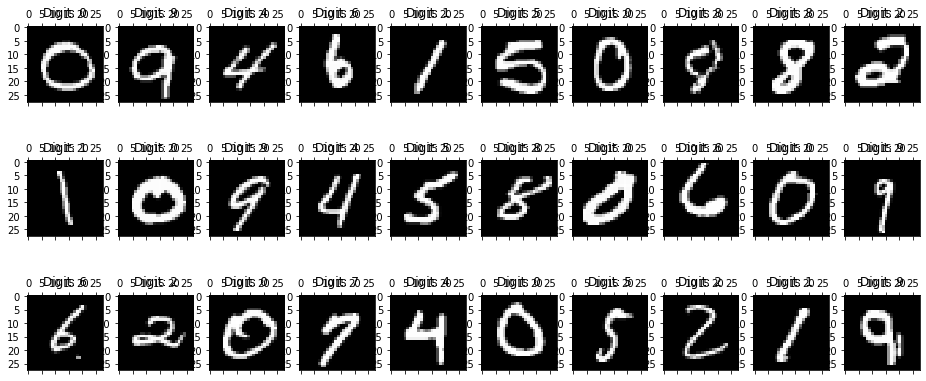

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,30):
    ax = fig.add_subplot(3,10,i+1, title='Digit: ' + str(df.loc[rndperm[i],'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

Con este nuevo orden, podemos pensar especificamente en la problematica de distinguir los caracteres unos de otros a partir de algun tipo de algoritmo de aprendizaje automatico.

Algo tambien a considerar es que las imagenes son de 28x28 pixels lo cual nos da 784 dimensiones, cada una teniendo el valor especifico de cada pixel.


# PCA

In [25]:
from sklearn.decomposition import PCA

# realizamos el calculo de 3 componentes principales
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Varianza por componente principal: {}'.format(pca.explained_variance_ratio_))

Varianza por componente principal: [0.09746116 0.07155445 0.06149531]


In [26]:
# vemos cuanta varianza (informacion) estariamos acumulando 
np.sum(pca.explained_variance_ratio_[::-2])

0.15895646899195687

Dado que el porcentaje de varianza acumulada es bajo veamos si podemos ver graficando algun tipo de separacion entre los digitos, pero esta es una primera nocion numerica que nos indica que posiblementen no podamos analizarlo en 2 dimensiones correctamente.

## Visualizando la informacion de PCA en 2D

Podemos crear un scatter plot en dos dimensiones, de las dos primeras componentes principales que calculamos. Por otro lado dado que conocemos el label de cada uno de los features, podemos usarlo en la visualizacion para indicar el label que le corresponde a cada imagen (recuerden, cada imagen se corresponde con un numero de 0 a 9, y ese sera el label correspondiente)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

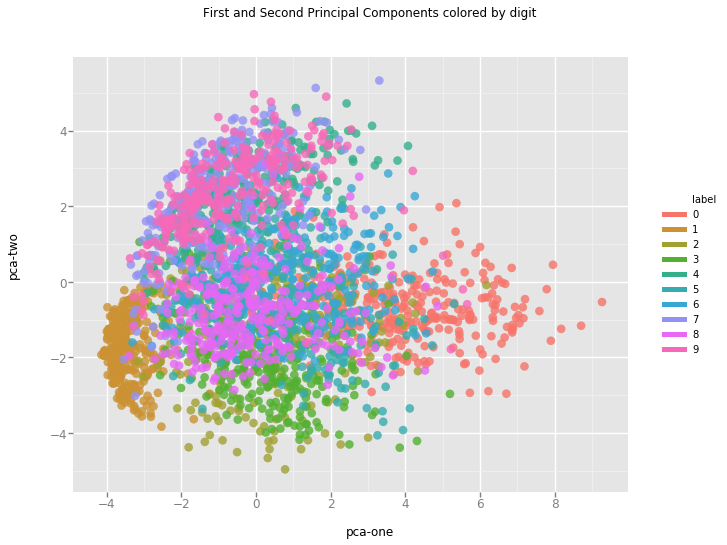

<ggplot: (-9223372036559867918)>

In [27]:
from ggplot import *

chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

De la visualizacion podemos ver que mas alla de que las dos componentes principales guardan cierta informacion en particular para algunos digitos, no tienen la suficiente informacion para diferenciar unas de otras en 2D. Es por eso que tenemos que buscar algun tipo de alternativa al respecto.

## t-SNE: T-Distributed Stochastic Neighbouring Entities

t-SNE es una tecnica de reduccion de dimensiones que es particularmente buena para la visualizacion de sets de datos de una gran cantidad de dimensiones. 

A diferencia de PCA, es una tecnica probabilistica que busca minimizar la divergencia entre dos distribuciones: una que mide las similitudes que hay entre pares de objetos de entrada y una distribucion que mide las similitudes que hay entre pares de objetos de entrada representados en menor cantidad de dimensiones.

### Aplicacion

El **metodo es computacionalmente intensivo por lo que tiene importantes limitaciones para trabajar al uso de esta tecnica** (en particular en gran cantidad de dimensiones y con muchos samples). 

Por otro lado tambien tiene otro problema de que como metodo escala cuadraticamente dado la cantidad N inputs que tenga, aumentando en tiempo y por ende uso de memoria.

**En casos en los que se este trabajando con una gran cantidad de dimensiones se propone por ejemplo utlizar antes otra tecnica de reduccion de dimensiones (en particular para PCA for dense data o TruncatedSVD) hasta reducirlo a un numero manejable de dimensiones.**

Referencia y contenido de interes: http://lvdmaaten.github.io/tsne/

In [28]:
# en nuestro ejemplo correremos el algoritmo con todas las dimensiones (784)
# pero con un numero limitado de objetos (7000), elegidos de forma random
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=3, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.324s...
[t-SNE] Computed neighbors for 7000 samples in 54.487s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 1.143131
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.991356
[t-SNE] KL divergence after 300 iterations: 3.901084
t-SNE done! Time elapsed: 75.47852730751038 seconds


## Visualizando el resultado de t-SNE sobre 784 dimensiones y 7000 samples

Podemos realizar un scatter plot similar al anterior para ver el resultado 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

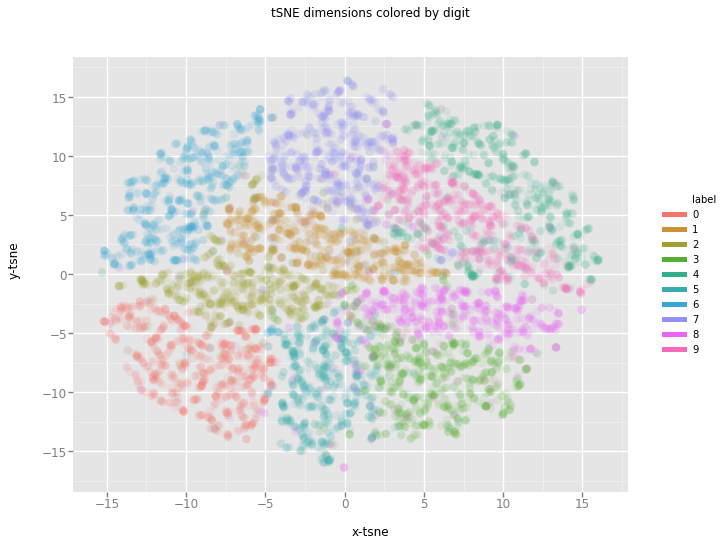

<ggplot: (277210411)>

In [30]:
from ggplot import *

df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

Analizando la visualizacion podemos ver que cada uno de los digitos ahora esta en un cluster mucho mas claro en la misma y que en cierta forma cada uno puede 

Facilmente podriamos entonces con algun metodo de clustering extraer los clusters y poder establecer un algoritmo para poder asignar el label correcto a un nuevo caracter.

# t-SNE on datos reducidos en 50 dimensiones via PCA

Siguiendo las recomendaciones iniciales, podemos ver que sucede reduciendo el numero de dimensiones con otro metodo previamente, por ejemplo PCA.

Luego ejecutaremos el algoritmo para llegar a dos dimensiones usando 10000 samples random.

In [31]:
# aplicamos PCA para obtener 50 componentes principales
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)
print('Varianza acumulada de 50 componentes principales: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Varianza acumulada de 50 componentes principales: 0.8253891693881419


In [ ]:
# ejecutamos el algoritmos sobre 10000 samples random
n_sne = 10000

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50[rndperm[:n_sne]])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.037s...
[t-SNE] Computed neighbors for 10000 samples in 12.799s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.860320


## Visualizando el resultado de t-SNE sobre 50 dimensiones obtenidas de PCA y 10000 samples

Podemos realizar un scatter plot similar al anterior para ver el resultado 

In [ ]:
df_tsne = None
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne-pca', y='y-tsne-pca', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by Digit (PCA)")
chart

Nuevamente podemos ver que ahora casi todos los caracteres estan claramente separados dejandonos la posibilidad de utilizar un algortimos de clustering.

In [8]:
#back to latest
!pip install pandas==0.25.1

  Using cached https://files.pythonhosted.org/packages/73/75/42a0ec87e4f709d8d37d49f049b292578f14a4f1f6dc32a7f3c3c204e546/pandas-0.25.1-cp36-cp36m-macosx_10_9_x86_64.macosx_10_10_x86_64.whl
  Found existing installation: pandas 0.19.2
    Uninstalling pandas-0.19.2:
      Successfully uninstalled pandas-0.19.2
